In [57]:
import numpy as np

def compute_psnr(original, reconstructed):
    """
    Calcule le PSNR entre l'image originale et l'image reconstruite.

    :param original: Image originale (numpy array, valeurs entre 0 et 1)
    :param reconstructed: Image reconstruite (numpy array, valeurs entre 0 et 1)
    :return: Valeur du PSNR en dB
    """
    mse = np.mean((original - reconstructed) ** 2)  # Erreur quadratique moyenne
    if mse == 0:
        return float('inf')  # PSNR infini si pas d'erreur
    max_pixel = 255.0  # L'image est normalisée entre 0 et 1
    psnr = 20 * np.log10(max_pixel / np.sqrt(mse))  # Formule PSNR
    return psnr


In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import scipy.io as sio
import numpy as np
import os
import glob
from time import time
import math
from torch.nn import init
import copy
import cv2
from skimage.metrics import structural_similarity as ssim
import matplotlib.pyplot as plt

# Configuration des paramètres
config = {
    "epoch_num": 200,
    "layer_num": 9,
    "learning_rate": 1e-4,
    "group_num": 1,
    "cs_ratio": 1,
    "gpu_list": "0",
    "matrix_dir": "sampling_matrix",
    "model_dir": "model",
    "data_dir": "data",
    "log_dir": "log",
    "result_dir": "result",
    "test_name": "Set11"
}

# Configuration GPU
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = config["gpu_list"]
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

ratio_dict = {1: 10, 4: 43, 10: 109, 25: 272, 30: 327, 40: 436, 50: 545}
n_input = ratio_dict[config["cs_ratio"]]
n_output = 1089

# Chargement de la matrice de sampling
Phi_data_Name = f'./{config["matrix_dir"]}/phi_0_{config["cs_ratio"]}_1089.mat'
Phi_data = sio.loadmat(Phi_data_Name)
Phi_input = Phi_data['phi']

# Définition du modèle ISTA-Net
class BasicBlock(torch.nn.Module):
    def __init__(self):
        super(BasicBlock, self).__init__()
        self.lambda_step = nn.Parameter(torch.Tensor([0.5]))
        self.soft_thr = nn.Parameter(torch.Tensor([0.01]))
        self.conv1_forward = nn.Parameter(init.xavier_normal_(torch.Tensor(32, 1, 3, 3)))
        self.conv2_forward = nn.Parameter(init.xavier_normal_(torch.Tensor(32, 32, 3, 3)))
        self.conv1_backward = nn.Parameter(init.xavier_normal_(torch.Tensor(32, 32, 3, 3)))
        self.conv2_backward = nn.Parameter(init.xavier_normal_(torch.Tensor(1, 32, 3, 3)))
    
    def forward(self, x, PhiTPhi, PhiTb):
        x = x - self.lambda_step * torch.mm(x, PhiTPhi)
        x = x + self.lambda_step * PhiTb
        x_input = x.view(-1, 1, 33, 33)
        x = F.relu(F.conv2d(x_input, self.conv1_forward, padding=1))
        x_forward = F.conv2d(x, self.conv2_forward, padding=1)
        x = torch.mul(torch.sign(x_forward), F.relu(torch.abs(x_forward) - self.soft_thr))
        x = F.relu(F.conv2d(x, self.conv1_backward, padding=1))
        x_backward = F.conv2d(x, self.conv2_backward, padding=1)
        x_pred = x_backward.view(-1, 1089)
        return x_pred

class ISTANet(torch.nn.Module):
    def __init__(self, LayerNo):
        super(ISTANet, self).__init__()
        self.LayerNo = LayerNo
        self.fcs = nn.ModuleList([BasicBlock() for _ in range(LayerNo)])
    
    def forward(self, Phix, Phi, Qinit):
        PhiTPhi = torch.mm(Phi.T, Phi)
        PhiTb = torch.mm(Phix, Phi)
        x = torch.mm(Phix, Qinit.T)
        for layer in self.fcs:
            x = layer(x, PhiTPhi, PhiTb)
        return x

# Chargement du modèle
model = ISTANet(config["layer_num"])
model = nn.DataParallel(model).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=config["learning_rate"])

model_dir = f"./{config['model_dir']}/CS_ISTA_Net_layer_{config['layer_num']}_group_{config['group_num']}_ratio_{config['cs_ratio']}_lr_{config['learning_rate']:.4f}"
model.load_state_dict(torch.load(f'{model_dir}/net_params_{config["epoch_num"]}.pkl', map_location=device))


<All keys matched successfully>

In [44]:
lambda_fista = model.state_dict()['module.fcs.8.lambda_step'].item()
soft_thr_fista = model.state_dict()['module.fcs.8.soft_thr'].item()

conv1_f = model.state_dict()['module.fcs.8.conv1_forward'].detach().cpu().numpy()
conv2_f = model.state_dict()['module.fcs.8.conv2_forward'].detach().cpu().numpy()
conv1_b = model.state_dict()['module.fcs.8.conv1_backward'].detach().cpu().numpy()
conv2_b = model.state_dict()['module.fcs.8.conv2_backward'].detach().cpu().numpy()

In [45]:
lambda_fista, soft_thr_fista

(2.4471731185913086, -0.018895795568823814)

In [52]:
import numpy as np
import scipy.signal

def soft_thresholding(x, threshold):
    return np.sign(x) * np.maximum(np.abs(x) - threshold, 0)

def convolve2d(x, kernel):
    """ Convolution 2D avec padding symétrique """
    return scipy.signal.convolve2d(x, kernel, mode='same', boundary='symm')

def fista_conv(y, Phi, PhiT, conv1_f, conv2_f, conv1_b, conv2_b, lambda_fista, soft_thr_fista, num_iters=50):
    """
    Implémentation de FISTA en utilisant les convolutions apprises de ISTA-Net.
    - y : observation (M, 1)
    - Phi : matrice de mesure (M, N)
    - PhiT : transposée de Phi (N, M)
    """

    N = PhiT.shape[0]  # Taille de la reconstruction (doit être 1089 pour ISTA-Net)
    H, W = 33, 33  # Dimensions d'image attendues (carré parfait pour convolution)

    x = np.dot(PhiT, y)  # Estimation initiale (N, 1)
    x = x.reshape(H, W)  # Reshape en image

    t = 1
    z = x.copy()

    for k in range(num_iters):
        gradient = np.dot(PhiT, np.dot(Phi, z.flatten())) - np.dot(PhiT, y).flatten()
        x_new = soft_thresholding(z.flatten() - lambda_fista * gradient, lambda_fista)
        x_new = x_new.reshape(H, W)  # Reshape en image 2D

        # Appliquer les convolutions apprises
        x_conv1 = convolve2d(x_new, conv1_f[0, 0])
        x_relu1 = np.maximum(x_conv1, 0)
        x_conv2 = convolve2d(x_relu1, conv2_f[0, 0])
        
        x_thresh = soft_thresholding(x_conv2, soft_thr_fista)

        x_conv3 = convolve2d(x_thresh, conv1_b[0, 0])
        x_relu2 = np.maximum(x_conv3, 0)
        x_conv4 = convolve2d(x_relu2, conv2_b[0, 0])

        x_final = x_conv4  # Image reconstruite

        # Mise à jour de FISTA
        t_new = (1 + np.sqrt(1 + 4 * t**2)) / 2
        z = x_final + ((t - 1) / t_new) * (x_final - x)
        x, t = x_final, t_new
        # print("Iteration", k, "- Min:", x_final.min(), "Max:", x_final.max())


    return x_final  # Image (33x33)


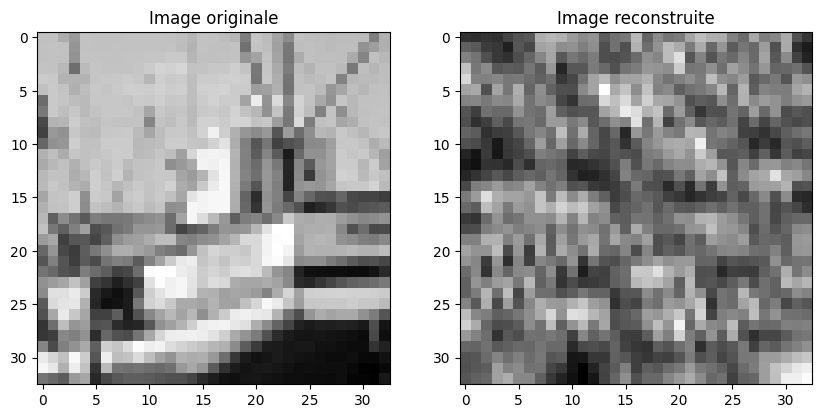

Shape de Phi : (109, 1089)
Shape de x_true : (1089, 1)
Shape de y : (109, 1)
Min: 0.0 Max: 1.0
PSNR de l'image reconstruite : 5.40 dB


In [61]:
# Charger la matrice Phi depuis le fichier .mat
Phi_data = sio.loadmat("sampling_matrix/phi_0_10_1089.mat")  # Adapte le chemin si nécessaire
Phi = Phi_data['phi']  # Extraction de la matrice
PhiT = Phi.T  # Transposée de Phi


# Charger une image .tif en niveaux de gris
image = cv2.imread("data/Set11/boats.tif", cv2.IMREAD_UNCHANGED)

# Vérifier la profondeur de l'image et normaliser en conséquence
# if image.dtype == np.uint8:
#     image = image.astype(np.float32) / 255.0  # Normalisation pour images 8 bits
# elif image.dtype == np.uint16:
#     image = image.astype(np.float32) / 65535.0  # Normalisation pour images 16 bits

# # Redimensionner en 33x33 (si nécessaire)
image = cv2.resize(image, (33, 33), interpolation=cv2.INTER_AREA)

# Vectorisation
x_true = image.flatten().reshape(-1, 1)  # (1089, 1)

y = np.dot(Phi, x_true)  # (M, 1)

# Reconstruction avec FISTA
x_reconstructed = fista_conv(
    y, Phi, PhiT, conv1_f, conv2_f, conv1_b, conv2_b,
    lambda_fista, soft_thr_fista, num_iters=50
)

# Normalisation des valeurs reconstruites
x_reconstructed = x_reconstructed - x_reconstructed.min()  # Décaler vers 0
x_reconstructed = x_reconstructed / x_reconstructed.max()  # Mettre entre 0 et 1


# Afficher l'image originale et reconstruite
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image, cmap="gray")
plt.title("Image originale")

plt.subplot(1, 2, 2)
plt.imshow(x_reconstructed, cmap="gray")
plt.title("Image reconstruite")

plt.show()

# plt.imshow(x_reconstructed, cmap="gray", vmin=0, vmax=1)
print("Shape de Phi :", Phi.shape)
print("Shape de x_true :", x_true.shape)
print("Shape de y :", y.shape)


print("Min:", x_reconstructed.min(), "Max:", x_reconstructed.max())

psnr_value = compute_psnr(image, x_reconstructed)
print(f"PSNR de l'image reconstruite : {psnr_value:.2f} dB")

In [51]:
# Générer une matrice Phi et un signal y avec la bonne taille
N = 1089  # Taille de l'image aplatie (33x33)
M = N // 2  # Moitié des mesures
A = np.random.randn(M, N)  # Matrice de mesure (M x N)
y = np.random.randn(M, 1)  # Signal observé (M x 1)
A_T = A.T  # Transposée de Phi

# Reconstruction avec FISTA utilisant les poids de ISTA-Net
x_reconstructed = fista_conv(y, A, A_T, conv1_f, conv2_f, conv1_b, conv2_b, lambda_fista, soft_thr_fista)

print("Reconstruction terminée !")
print("Taille de l'image reconstruite :", x_reconstructed.shape)  # Doit être (33, 33)


Reconstruction terminée !
Taille de l'image reconstruite : (33, 33)
